In [503]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # Windows
!pip3 install torch torchvision torchaudio # MacOS

# Импорты и константы

In [504]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
import requests
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import ceil

import missingno
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
torch.cuda.is_available()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 1220

In [505]:
data_path_local = './datasets/autos.csv'
data_path_web = 'https://code.s3.yandex.net/datasets/6_class.csv'

if os.path.exists(data_path_local):
    data = pd.read_csv(data_path_local, index_col = 'Unnamed: 0')
elif requests.head(data_path_web).status_code == 200:
    data = pd.read_csv(data_path_web, index_col = 'Unnamed: 0')
else:
    print('Something is wrong')

# Исследовательский анализ данных

## Обзор данных

In [506]:
def info_df(df):
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('-----------------------------------------')
    print('| Первые и последние 5 строчек датасета |')
    print('-----------------------------------------')
    display(df)
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('----------------------')
    print('| Целостность данных |')
    print('----------------------')
    missingno.matrix(df)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


--------------------
| Сумма дубликатов |
--------------------
0
----------------------
| Целостность данных |
----------------------


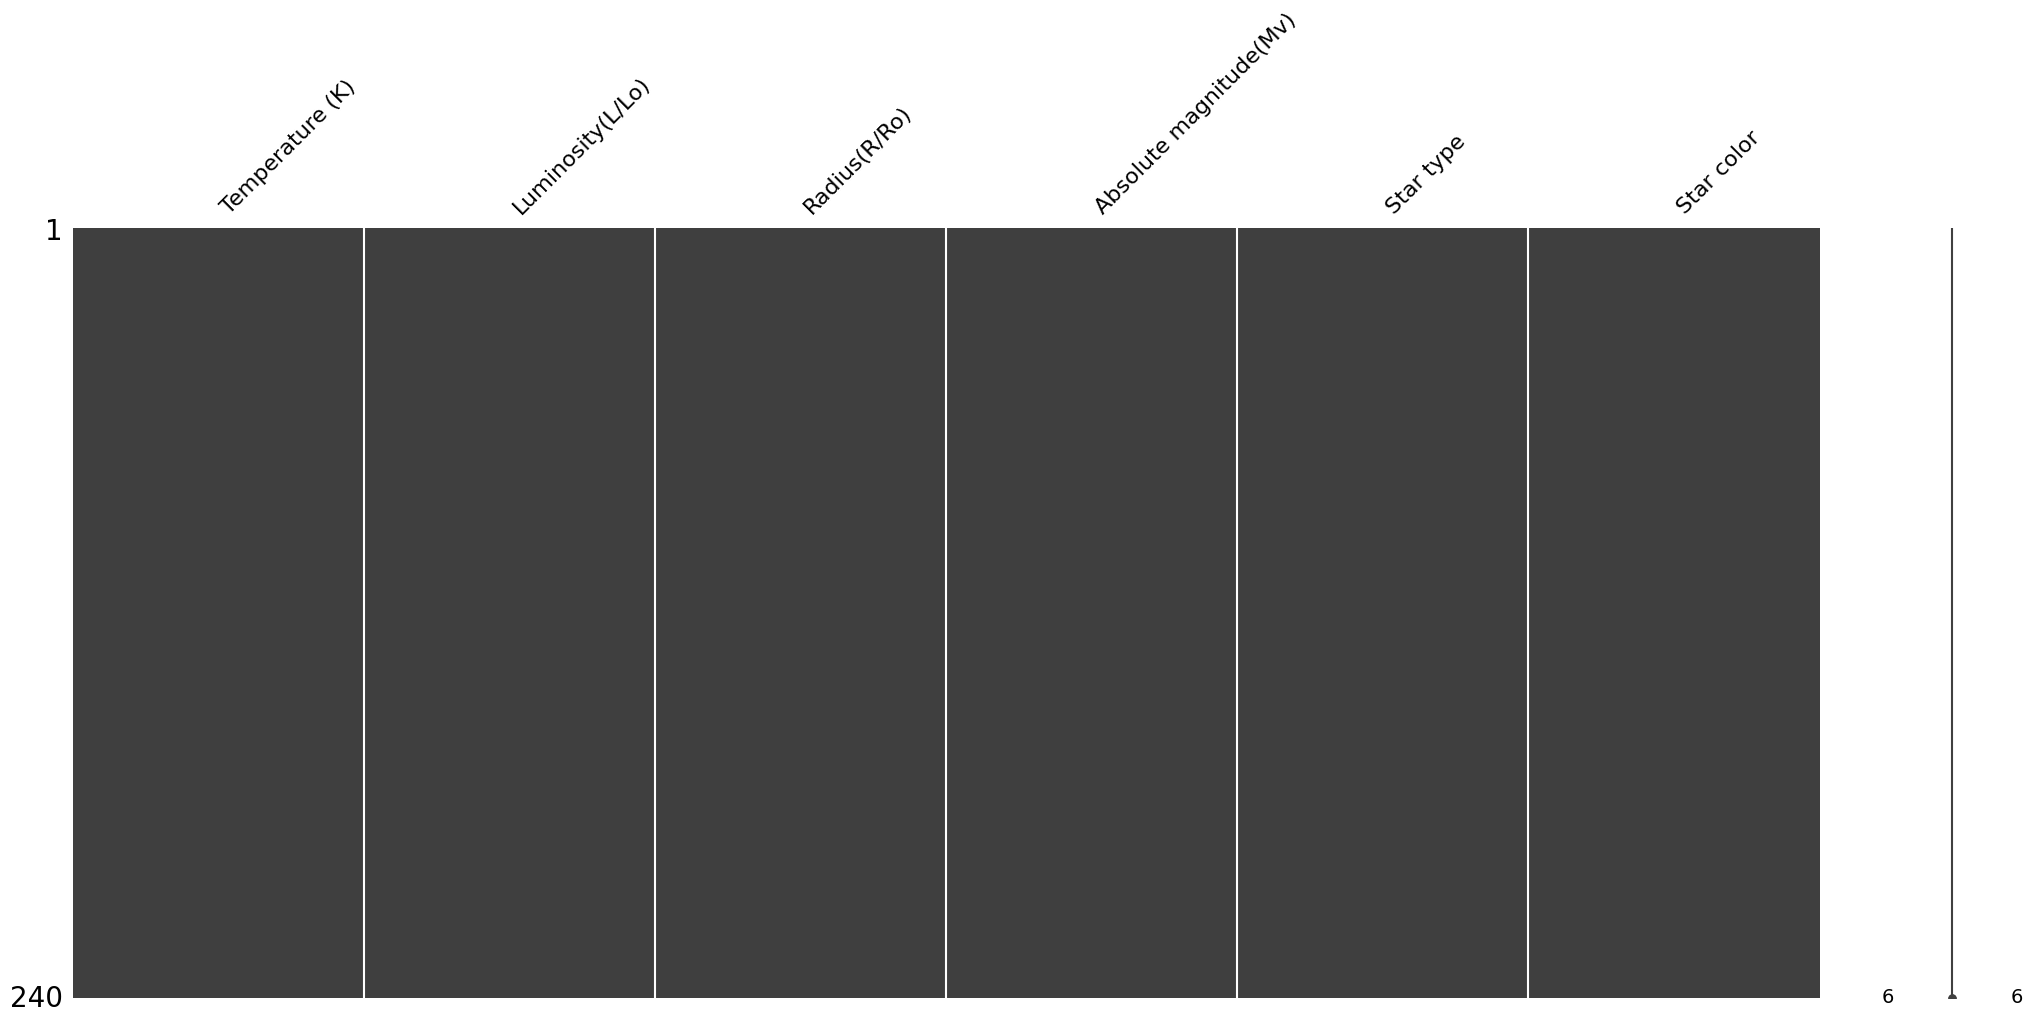

In [507]:
info_df(data)

При первичном обзоре данных, дубликатов не выявлено, типы данных соответвуют.

## Пропуски и неявные дубликаты

In [508]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
Temperature (K),0.000000
Luminosity(L/Lo),0.000000
Radius(R/Ro),0.000000
Absolute magnitude(Mv),0.000000
Star type,0.000000
Star color,0.000000


In [509]:
data['Star color'] = data['Star color'].str.strip()
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

В признаке цвет звезды имеются неявные дубликаты

In [510]:
data = data.apply(lambda x: x.replace({'Blue white':'Blue White', 'Blue-white':'Blue White',
                                       'Blue-White':'Blue White','white':'White',
                                       'yellow-White':'White-Yellow','yellow-white':'White-Yellow',
                                       'yellowish':'Yellowish'}, regex=True))

In [511]:
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White',
       'Pale yellow orange', 'Blue', 'Whitish', 'yellow-White', 'Orange',
       'White-Yellow', 'Yellowish', 'Orange-Red'], dtype=object)

Неявные дубликаты убраны

## Корреляция и расспределения признаков

Для анализа корреляции в неоднородном наборе данных по типу, предлагается использовать корреляциюя $\phi_K$

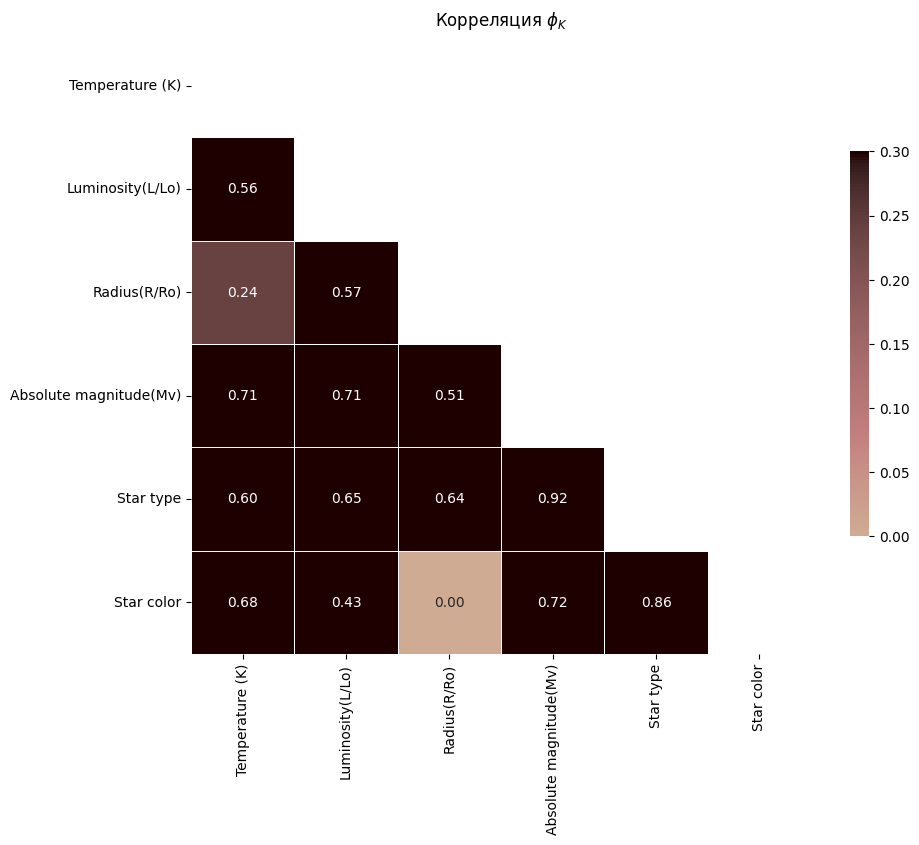

In [512]:
interval_cols = data.columns[:-2] # Без типа и цвета звезды
phik_overview = data.phik_matrix(interval_cols=interval_cols)



plt.figure(figsize=(10, 10))
plt.title(r'Корреляция $\phi_K$')
corr = phik_overview.round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
        annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Помимо корреляции, следует проверять и статистическую значимость данных признаков, дабы убедиться в анализе корреляции

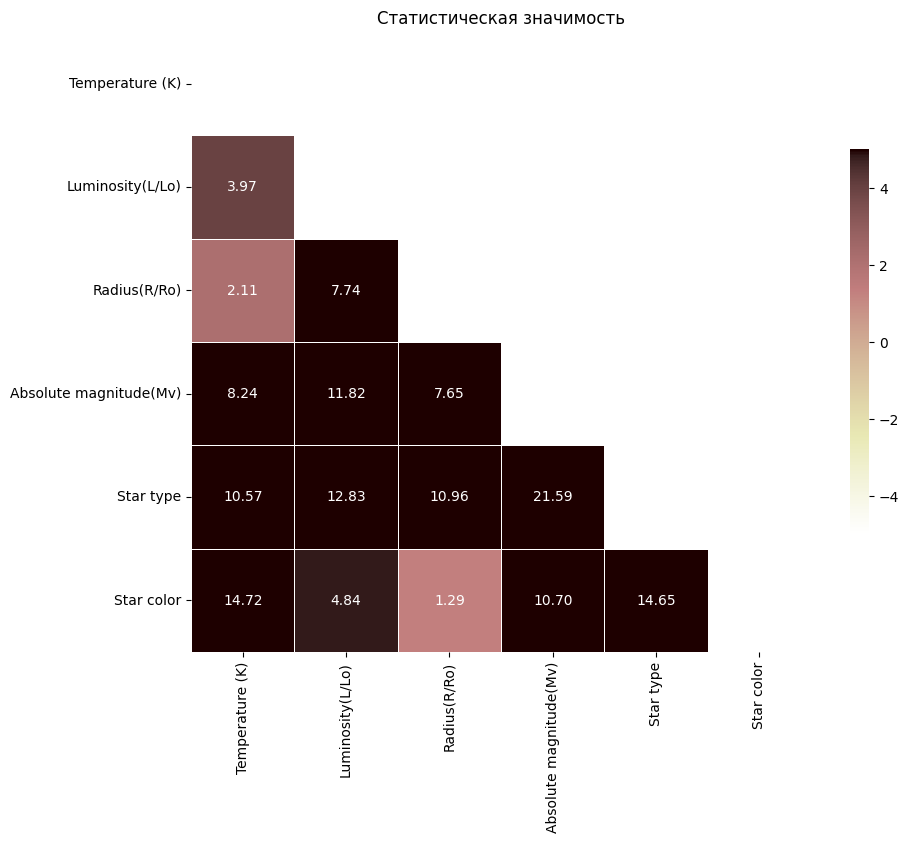

In [513]:
significance_overview  = data.significance_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 10))
plt.title('Статистическая значимость')
corr = significance_overview.round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
           annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Рассмотрим расспределения данных

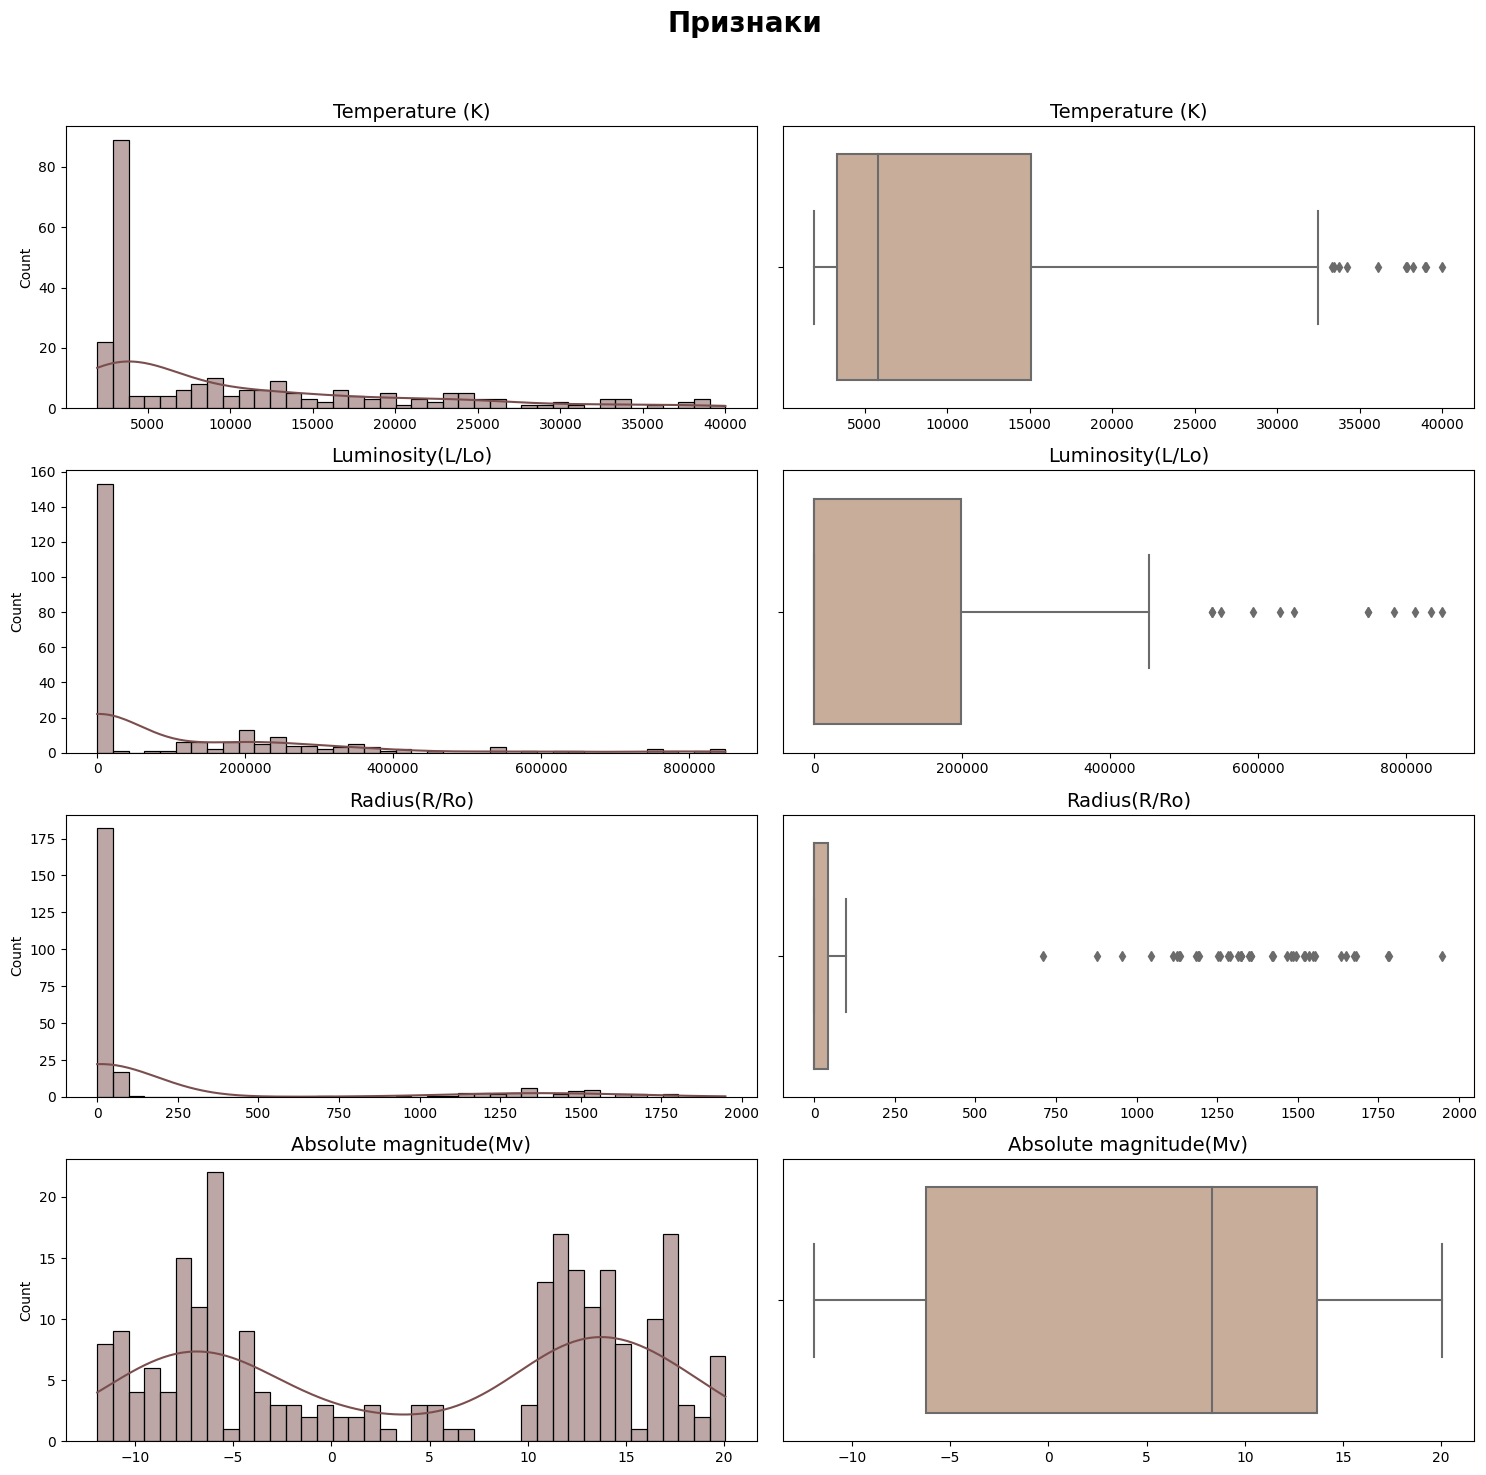

In [514]:
fig, axes = plt.subplots(nrows=len(data[interval_cols].columns), ncols=2, figsize=(15, 15))
j = 0
for i in data[interval_cols].columns:
    sb.histplot(data[interval_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black', color=sb.color_palette("pink")[0])
    axes[j, 0].set_title(i, fontsize=14)
    axes[j, 0].set_xlabel('')

    sb.boxplot(x=data[interval_cols][i], ax=axes[j, 1], orient='h', palette="pink")
    axes[j, 1].set_title(i, fontsize=14)
    axes[j, 1].set_xlabel('')
    j += 1

plt.suptitle(f'Признаки\n\n', ha='center', fontweight='bold', fontsize=20)
plt.tight_layout()
plt.show()

Стоит обратить внимание на то что количество выбрасов в радиусе звезд значительно привышает количество в других параметрах, таких как светимость или температура, которые могли бы говорить об уникальности звезд. Предлагается отфильтровать данные по значению радиуса до уровня одного стандартного отклонения. На наличие аномальных значений также указывает и параметр корреляции который в сравнении с другими параметрами сильно ниже. Посмотрим как измениться это значение после фильтрации.

In [515]:
data = data.loc[data['Radius(R/Ro)'] < data['Radius(R/Ro)'].std()]

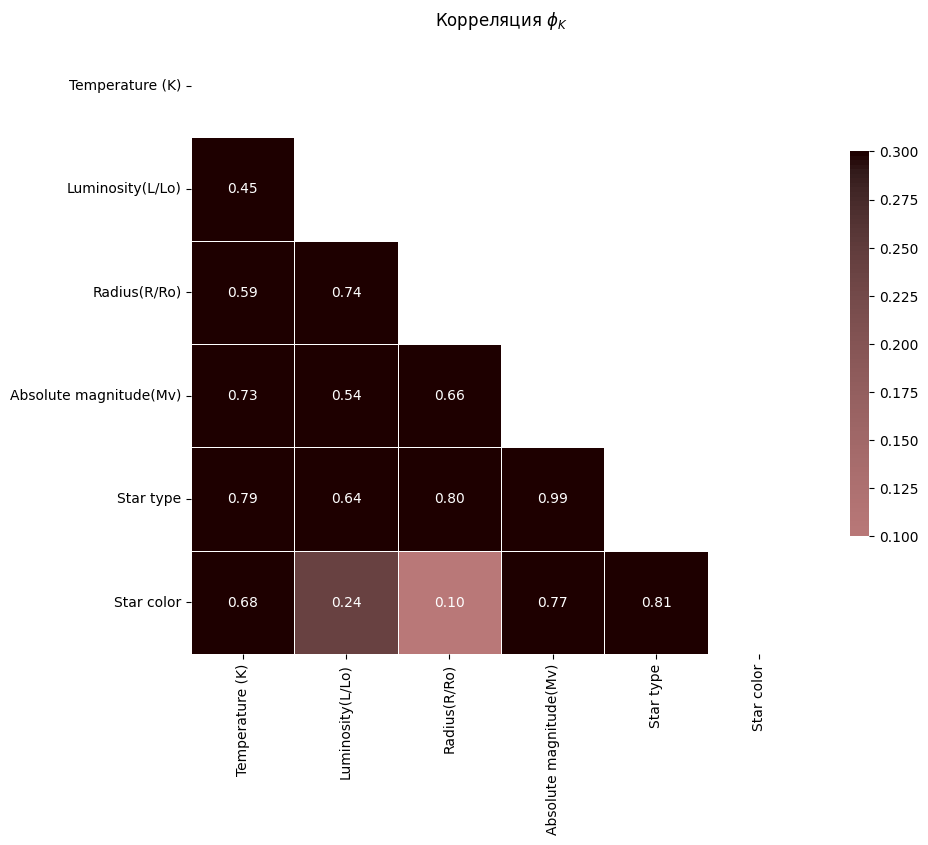

In [516]:
interval_cols = data.columns[:-2] # Без типа и цвета звезды
phik_overview = data.phik_matrix(interval_cols=interval_cols)



plt.figure(figsize=(10, 10))
plt.title(r'Корреляция $\phi_K$')
corr = phik_overview.round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
        annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Как можно заметить, после выполненой фильрции корреляция выросла между температурой и радиусом и сильно снизилиась между цветом звезды и температурой.

In [517]:
data[interval_cols].describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,200.000000,200.000000,200.000000,200.000000
mean,10315.815000,66776.728962,11.209838,7.189725
std,9056.734463,145023.376295,23.558904,9.235463
min,1939.000000,0.000080,0.008400,-7.450000
25%,3253.500000,0.000685,0.093150,-3.702500
50%,6928.500000,0.003645,0.338000,11.450000
75%,14794.500000,12962.500000,6.367500,14.237500
max,40000.000000,813000.000000,98.000000,20.060000


**Выводы**


В результате анализа данных были выявлены и отфильтрованы выбросы в параметре Радиус по значению одного стандартного отклонения. Пропусков в данных нет, однако были обнаружены неявные дубликаты в описании цветов звезд, дубликаты были устранены.

# Предобработка признаков

In [518]:
features = data.drop(['Temperature (K)'], axis = 1)
target = data['Temperature (K)']

In [519]:
features_train, features_test, target_train, target_test \
    = train_test_split(features, target, test_size = 0.25, random_state = RANDOM_STATE)

## Кодирование категориальных данных 

In [520]:
ohe_features = features.select_dtypes(include='object').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='object').columns.to_list()
num_features

['Star color']


['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']

In [521]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
features_ohe_train = features_train.copy()

encoder_ohe.fit(features_ohe_train[ohe_features])

transformed = encoder_ohe.transform(features_ohe_train[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_train.index)

features_ohe_train = pd.concat([features_ohe_train, ohe_df], axis=1).drop(ohe_features, axis=1)

In [522]:
features_ohe_test = features_test.copy()
transformed = encoder_ohe.transform(features_ohe_test[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_test.index)

features_ohe_test = pd.concat([features_ohe_test, ohe_df], axis=1).drop(ohe_features, axis=1)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Анализ мультиколлениарности и масштабирование признаков

In [523]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_ohe_train.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(features_ohe_train.values, i) \
                          for i in range(len(features_ohe_train.columns))]

print(vif_data)

                       feature       VIF
0             Luminosity(L/Lo)  3.538384
1                 Radius(R/Ro)  3.372003
2       Absolute magnitude(Mv)  4.053950
3                    Star type  7.207567
4        Star color_Blue White  2.425722
5        Star color_Orange-Red  1.077352
6               Star color_Red  3.767583
7             Star color_White  1.493702
8      Star color_White-Yellow  1.083524
9           Star color_Whitish  1.133707
10        Star color_Yellowish  1.161255
11  Star color_Yellowish White  1.159686
12     Star color_yellow-White  1.444873


Судя по значениям вздутия дисперсии можно предположить, что параметр Тип звезды является лишним в наборе данных, но согласно негласным правилам, если значение VIF не достигло хотя бы 9.0, то параметр стоит оставть, что мы и сделаем.

In [531]:
X_train, X_test, Y_train, Y_test = torch.tensor(features_ohe_train.values, dtype=torch.float32),\
                                   torch.tensor(features_ohe_test.values, dtype=torch.float32),\
                                   torch.tensor(target_train.values, dtype=torch.float32),\
                                   torch.tensor(target_test.values, dtype=torch.float32)

In [532]:
scaler = StandardScaler()
X_train_slr = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_slr = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# Разработка класса нейронной сети

Архитектура данной сети прямого распространнения, представляет из себя адаптивную модель, с возможностью создания объекта сети с N-мернымы скрытыми слоями, с подключением технологий BatchNormaliztion и Dropout.

Функция активации для всех слоев - ReLU

    - input_dim (int): количество входных нейронов (количество признаков)
    - hidden_lyrs (list[int]): список элементами которого являются количества нейронов на каждом скрытом слое (индекс - номер слоя : значение - количество нейронов в слое)
    - output_dim (int): количество выходных нейронов
    - batch_norm (bool): логическое значение для учета технологии BatchNormaliztion
    - dropout (bool): логическое значение для учета технологии Dropout

* BatchNormaliztion - реализация технологии BatchNormaliztion в модели сети, автоматически задает значения в зависимости от скрытого слоя
* Dropout - для технологии Dropout используется генератор псевдослучайных чисел в диапазоне 0.1 - 0.5, невозможность "настраивать" значения является частью архитектуры предложенной модели

<div class="alert alert-info">
    <b>Комментарий студента:</b> Я понимаю что рандом с Dropout повлияет на репрезентативность и наверное его хотелось бы руками задавать, но на сколько я понял, даже после того как мы руками укажим долю отключеных нейроной, функция сама решит какие отключить и я так понимаю рандомно, посему считаю что такое решение может быть легальным, но если я ошибаюсь, то переделаю
</div>

In [533]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim: int, hidden_lyrs: list[int], output_dim: int, batch_norm=False, dropout=False):
        super(NeuralNet, self).__init__()
        self.relu = nn.ReLU()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.hidden_lyrs = hidden_lyrs
        if batch_norm == False and dropout == False:
            if len(hidden_lyrs) > 1:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = [nn.Linear(hidden_lyrs[i], hidden_lyrs[i+1]) for i in range(0, len(hidden_lyrs)-1)]
                self.syn_out = nn.Linear(hidden_lyrs[-1], output_dim)
            else:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = []
                self.syn_out = nn.Linear(hidden_lyrs[0], output_dim)
        elif batch_norm == True and dropout == False:
            if len(hidden_lyrs) > 1:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = [[nn.Linear(hidden_lyrs[i], hidden_lyrs[i+1]), nn.BatchNorm1d(hidden_lyrs[i+1])] for i in range(len(hidden_lyrs)-1)]
                self.syn_out = nn.Linear(hidden_lyrs[-1], output_dim)
            else:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = []
                self.syn_out = nn.Linear(hidden_lyrs[0], output_dim)
        elif batch_norm == False and dropout == True:
            if len(hidden_lyrs) > 1:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = [[nn.Linear(hidden_lyrs[i], hidden_lyrs[i+1]), nn.Dropout(np.random.uniform(0.1, 0.5))] for i in range(len(hidden_lyrs)-1)]
                self.syn_out = nn.Linear(hidden_lyrs[-1], output_dim)
            else:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = []
                self.syn_out = nn.Linear(hidden_lyrs[0], output_dim)
        else:
            if len(hidden_lyrs) > 1:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = [[nn.Linear(hidden_lyrs[i], hidden_lyrs[i+1]), nn.BatchNorm1d(hidden_lyrs[i+1]), nn.Dropout(np.random.uniform(0.1, 0.5))] for i in range(len(hidden_lyrs)-1)]
                self.syn_out = nn.Linear(hidden_lyrs[-1], output_dim)
            else:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = []
                self.syn_out = nn.Linear(hidden_lyrs[0], output_dim)
        


    def forward(self, x):
        if self.batch_norm == False and self.dropout == False:
            out = self.relu(self.syn_in(x))
            if len(self.hidden_syns) > 1: 
                for syn in self.hidden_syns:
                    out = self.relu(syn(out))
            return self.relu(self.syn_out(out))
        elif self.batch_norm == True and self.dropout == False:
            f_b = nn.BatchNorm1d(self.hidden_lyrs[0])
            out = self.relu(f_b(self.syn_in(x)))
            if len(self.hidden_syns) > 1:
                for syn in self.hidden_syns:
                    out = self.relu(syn[1](syn[0](out)))
            return self.relu(self.syn_out(out))
        elif self.batch_norm == False and self.dropout == True:
            f_d = nn.Dropout(np.random.uniform(0.1, 0.5))
            out = f_d(self.relu(self.syn_in(x)))
            if len(self.hidden_syns) > 1:
                for syn in self.hidden_syns:
                    out = syn[1](self.relu(syn[0](out)))
            return self.relu(self.syn_out(out))
        else:
            f_d = nn.Dropout(np.random.uniform(0.1, 0.5))
            f_b = nn.BatchNorm1d(self.hidden_lyrs[0])
            out = f_d(self.relu(f_b(self.syn_in(x))))
            if len(self.hidden_syns) > 1:
                for syn in self.hidden_syns:
                    out = syn[2](self.relu(syn[1](syn[0](out))))
            return self.relu(self.syn_out(out))

Ниже представлены функции для тренировки модели, подбора параметров обучения и отрисовки результатов прогнозирования

In [574]:
# Функция train_model предназначена для обучения модели и принимает в качестве параметров:
#   model       ->  Объект класса NeuralNet
#   batch_size  ->  Размер батча
#   optimizer   ->  Функция оптимизации
#   X,Y         ->  Тензор признаков и целевой соответсвтенно
#   epochs      ->  Количество эпох
#   btnr, drpt  ->  BatchNormaliztion и Dropout соответсвтенно
#
# Функцией потерь является MSE, но в лог выводится RMSE
def train_model(model: NeuralNet, batch_size: int, optimizer, 
                X: torch.Tensor, Y: torch.Tensor, epochs: int, btnr=False, drpt=False):
    num_batches = ceil(len(X)/batch_size)
    criterion = nn.MSELoss()
    accumulation_iteration = 5
    for i in range(epochs):
        order = np.random.permutation(len(X))
        optimizer.zero_grad()
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X[batch_indexes]
            y_batch = Y[batch_indexes]

            preds = model(X_batch).flatten()

            loss = criterion(preds.ravel(), y_batch) / accumulation_iteration

            loss.backward()
            optimizer.step()
            if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                optimizer.step()
                optimizer.zero_grad()
        
        if i % 50000 == 0 or i == epochs-1:
            print("Epoch: {} RMSE : {:.2f}".format(i, torch.sqrt(loss)))


# Функция model_conveyor предназначена для выбора наилучшей модели и принимает в качестве параметров:
#   input       ->  Количество нейронов на входном слое
#   hidden      ->  Количество скрытых слоев и нейрнов в них
#   output      ->  Количество выходных нейронов
#   X,Y         ->  Тензор признаков и целевой соответсвтенно
#   btnr, drpt  ->  BatchNormaliztion и Dropout соответсвтенно
#
# Функция возвращает объект моедли нейронной сети
def model_conveyor(input: int, hidden: list[int], output: int, X: torch.Tensor, Y: torch.Tensor, btnr=False, drpt=False) -> NeuralNet:
    learning_rate = [1e-1,1e-2,1e-3]
    batch_size = [100,150,200]
    epochs = [50000,100000,150000]
    RMSE = 4500 
    best_model = None
    for lr in learning_rate:
        for bs in batch_size:
            for eph in epochs:
                    print(f'learning rate: {lr}, batch size: {bs}, epochs: {eph}')

                    model = NeuralNet(input_dim=input, hidden_lyrs=hidden, output_dim=output, dropout=btnr, batch_norm=drpt)
                    
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    train_model(model, bs, optimizer, X, Y, eph, btnr=btnr, drpt=drpt)
                    test_pred = model(X_test_slr)
                    RMSE_test = mean_squared_error(Y_test.detach().numpy(), test_pred.detach().numpy().squeeze())**0.5
                    if RMSE_test <= RMSE:
                        best_model = model
                        RMSE = RMSE_test
                        train_pred = model(X)
                        RMSE_pred = mean_squared_error(Y.detach().numpy(), train_pred.detach().numpy().squeeze())**0.5
                        results = {
                            'Parameters' : ['Learning Rate', 'Batch Size', 'Epochs', 'RMSE Train', 'RMSE Test'],
                            'Model' : pd.Series([lr, bs, eph, RMSE_pred, RMSE]),
                            }
                        display(pd.DataFrame(results))
    return best_model


# Функция show_graph предназначена для выбора отображения прогноза и истинных значений согласно требованию заказчика
# Функция принимает параметр:
#   test_preds  ->  Тензор прогноза
def show_graph(test_preds: torch.Tensor):
    start = 0
    end = 15

    basic_df = Y_test[start:end]
    nn_df = test_preds[start:end]
    print('RMSE test:', 
          mean_squared_error(Y_test.detach().numpy(), test_preds.detach().numpy().squeeze())**0.5)
    plt.figure(figsize=(5, 5))
    plt.bar(range(start, end), nn_df.detach().numpy().squeeze(), color='#FFA500', label='Прогноз')
    plt.bar(range(start, end), basic_df.detach().numpy(), color='#E6DAA6', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз', fontsize=16)
    plt.xlabel('Номер звезды в таблице данных', fontsize=14)
    plt.ylabel('Температура звезды', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
                        

## Baseline

Обучим четыре типа нейронных сетей при четырех скрытых слоях с количеством нейронов 75, 50, 25, 10. Значение learning rate = 0.01, размер батча 100, количество итераций 50000

- Модель 1: Без использования технологий BatchNormaliztion и Dropout
- Модедь 2: Без использования технологии Dropout
- Модель 3: Без использования технологии BatchNormaliztion
- Модель 4: С использованием технологий BatchNormaliztion и Dropout

In [552]:
INPUT = len(features_ohe_train.columns)
HIDDEN = [75,50,25,10]
OUTPUT = 1

In [563]:
model_1 = NeuralNet(input_dim=INPUT, hidden_lyrs=HIDDEN, output_dim=OUTPUT)
                    
optimizer = torch.optim.Adam(model_1.parameters(), lr=.01)
train_model(model_1, 100, optimizer,X_train_slr,Y_train,50000)

Epoch: 0 RMSE : 6205.78
Epoch: 49999 RMSE : 772.54


RMSE test: 3827.678539271552


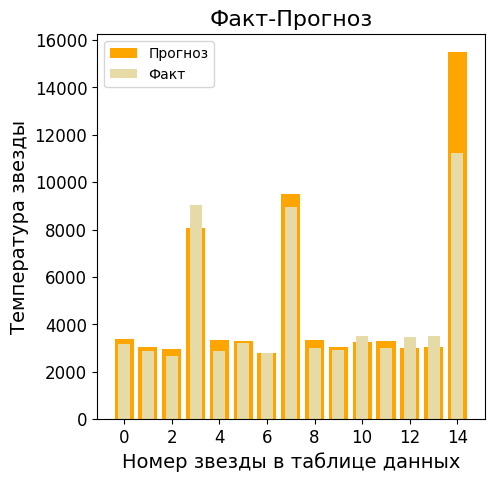

In [567]:
show_graph(model_1(X_test_slr))

In [564]:
model_2 = NeuralNet(input_dim=INPUT, hidden_lyrs=HIDDEN, output_dim=OUTPUT, batch_norm=True)
                    
optimizer = torch.optim.Adam(model_2.parameters(), lr=.01)
train_model(model_2, 100, optimizer,X_train_slr,Y_train,50000)

Epoch: 0 RMSE : 6139.26
Epoch: 49999 RMSE : 1869.82


RMSE test: 3421.7754163591744


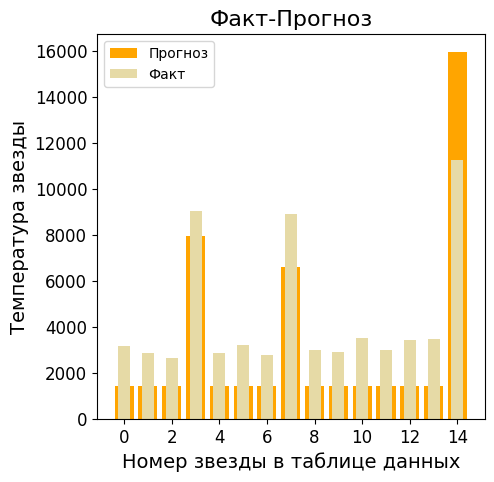

In [568]:
show_graph(model_2(X_test_slr))

In [569]:
model_3 = NeuralNet(input_dim=INPUT, hidden_lyrs=HIDDEN, output_dim=OUTPUT, dropout=True)
                    
optimizer = torch.optim.Adam(model_3.parameters(), lr=.01)
train_model(model_3, 100, optimizer,X_train_slr,Y_train,50000)

Epoch: 0 RMSE : 7330.92
Epoch: 49999 RMSE : 2875.27


RMSE test: 4772.280167802389


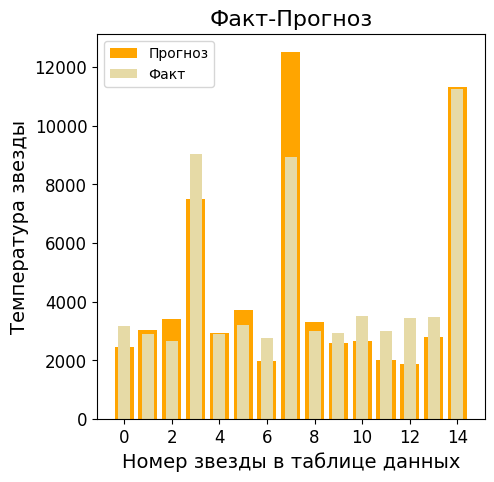

In [570]:
show_graph(model_3(X_test_slr))

In [571]:
model_4 = NeuralNet(input_dim=INPUT, hidden_lyrs=HIDDEN, output_dim=OUTPUT, batch_norm=True, dropout=True)
                    
optimizer = torch.optim.Adam(model_4.parameters(), lr=.01)
train_model(model_4, 100, optimizer,X_train_slr,Y_train,50000)

Epoch: 0 RMSE : 5615.06
Epoch: 49999 RMSE : 2016.44


RMSE test: 4826.704880143388


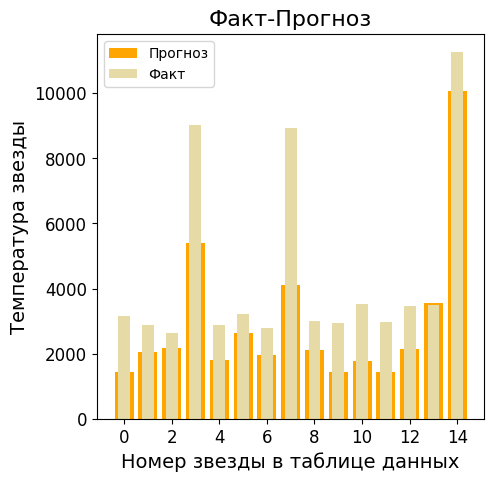

In [572]:
show_graph(model_4(X_test_slr))

**Выводы**

Из анализа обученых базовых моделей можно сделать предположение о целесообразности подбора параметров обучения для вариантов модели с и без технологии Dropout. Обучение с технологией BatchNormaliztion требует примерно в 5 раза больше времени, не имея при этом приемущество в точности

# Подбор оптимальных параметров

In [575]:
model = model_conveyor(INPUT, HIDDEN, OUTPUT, X_train_slr, Y_train)

learning rate: 0.1, batch size: 100, epochs: 50000
Epoch: 0 RMSE : 6672.52
Epoch: 49999 RMSE : 7319.46
learning rate: 0.1, batch size: 100, epochs: 100000
Epoch: 0 RMSE : 6872.13
Epoch: 50000 RMSE : 435.26
Epoch: 99999 RMSE : 405.82
learning rate: 0.1, batch size: 100, epochs: 150000
Epoch: 0 RMSE : 7062.08
Epoch: 50000 RMSE : 356.63
Epoch: 100000 RMSE : 237.84
Epoch: 149999 RMSE : 401.14


,Parameters,Model
0,Learning Rate,0.100000
1,Batch Size,100.000000
2,Epochs,150000.000000
3,RMSE Train,497.240950
4,RMSE Test,4053.846322


learning rate: 0.1, batch size: 150, epochs: 50000
Epoch: 0 RMSE : 6387.34
Epoch: 49999 RMSE : 243.22
learning rate: 0.1, batch size: 150, epochs: 100000
Epoch: 0 RMSE : 6387.34
Epoch: 50000 RMSE : 226.24
Epoch: 99999 RMSE : 209.18
learning rate: 0.1, batch size: 150, epochs: 150000
Epoch: 0 RMSE : 6387.30
Epoch: 50000 RMSE : 298.50
Epoch: 100000 RMSE : 209.52
Epoch: 149999 RMSE : 197.15
learning rate: 0.1, batch size: 200, epochs: 50000
Epoch: 0 RMSE : 6387.38
Epoch: 49999 RMSE : 239.68
learning rate: 0.1, batch size: 200, epochs: 100000
Epoch: 0 RMSE : 6387.28
Epoch: 50000 RMSE : 278.56
Epoch: 99999 RMSE : 258.67
learning rate: 0.1, batch size: 200, epochs: 150000
Epoch: 0 RMSE : 6387.28
Epoch: 50000 RMSE : 244.59
Epoch: 100000 RMSE : 211.45
Epoch: 149999 RMSE : 229.09
learning rate: 0.01, batch size: 100, epochs: 50000
Epoch: 0 RMSE : 6186.95
Epoch: 49999 RMSE : 746.38


,Parameters,Model
0,Learning Rate,0.010000
1,Batch Size,100.000000
2,Epochs,50000.000000
3,RMSE Train,1472.800564
4,RMSE Test,3811.095249


learning rate: 0.01, batch size: 100, epochs: 100000
Epoch: 0 RMSE : 6914.23
Epoch: 50000 RMSE : 839.34
Epoch: 99999 RMSE : 220.89
learning rate: 0.01, batch size: 100, epochs: 150000
Epoch: 0 RMSE : 6074.96
Epoch: 50000 RMSE : 665.73
Epoch: 100000 RMSE : 229.85
Epoch: 149999 RMSE : 300.70
learning rate: 0.01, batch size: 150, epochs: 50000
Epoch: 0 RMSE : 6387.38
Epoch: 49999 RMSE : 6387.38
learning rate: 0.01, batch size: 150, epochs: 100000
Epoch: 0 RMSE : 6387.34
Epoch: 50000 RMSE : 585.57
Epoch: 99999 RMSE : 261.74
learning rate: 0.01, batch size: 150, epochs: 150000
Epoch: 0 RMSE : 6387.34
Epoch: 50000 RMSE : 548.70
Epoch: 100000 RMSE : 299.77
Epoch: 149999 RMSE : 245.05
learning rate: 0.01, batch size: 200, epochs: 50000
Epoch: 0 RMSE : 6387.38
Epoch: 49999 RMSE : 6387.38
learning rate: 0.01, batch size: 200, epochs: 100000
Epoch: 0 RMSE : 6387.28
Epoch: 50000 RMSE : 497.58
Epoch: 99999 RMSE : 366.41
learning rate: 0.01, batch size: 200, epochs: 150000
Epoch: 0 RMSE : 6387.30
Ep

,Parameters,Model
0,Learning Rate,0.001000
1,Batch Size,100.000000
2,Epochs,150000.000000
3,RMSE Train,3364.415848
4,RMSE Test,3078.799766


learning rate: 0.001, batch size: 150, epochs: 50000
Epoch: 0 RMSE : 6387.38
Epoch: 49999 RMSE : 6387.38
learning rate: 0.001, batch size: 150, epochs: 100000
Epoch: 0 RMSE : 6387.38
Epoch: 50000 RMSE : 6387.38
Epoch: 99999 RMSE : 6387.38
learning rate: 0.001, batch size: 150, epochs: 150000
Epoch: 0 RMSE : 6387.28
Epoch: 50000 RMSE : 2018.36
Epoch: 100000 RMSE : 1523.28
Epoch: 149999 RMSE : 1309.02
learning rate: 0.001, batch size: 200, epochs: 50000
Epoch: 0 RMSE : 6387.38
Epoch: 49999 RMSE : 2099.50
learning rate: 0.001, batch size: 200, epochs: 100000
Epoch: 0 RMSE : 6387.37
Epoch: 50000 RMSE : 1917.59
Epoch: 99999 RMSE : 1496.02
learning rate: 0.001, batch size: 200, epochs: 150000
Epoch: 0 RMSE : 6387.35
Epoch: 50000 RMSE : 2001.18
Epoch: 100000 RMSE : 1490.08
Epoch: 149999 RMSE : 1289.04


RMSE test: 3078.799766142644


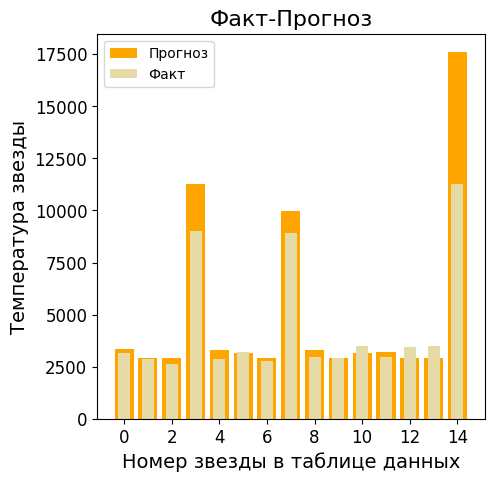

In [576]:
show_graph(model(X_test_slr))

In [578]:
model_drpt = model_conveyor(INPUT, HIDDEN, OUTPUT, X_train_slr, Y_train, drpt=True)

learning rate: 0.1, batch size: 100, epochs: 50000
Epoch: 0 RMSE : 6617.49
Epoch: 49999 RMSE : 1022.02


,Parameters,Model
0,Learning Rate,0.100000
1,Batch Size,100.000000
2,Epochs,50000.000000
3,RMSE Train,874.181617
4,RMSE Test,3259.182106


learning rate: 0.1, batch size: 100, epochs: 100000
Epoch: 0 RMSE : 6623.77
Epoch: 50000 RMSE : 671.59
Epoch: 99999 RMSE : 963.33
learning rate: 0.1, batch size: 100, epochs: 150000
Epoch: 0 RMSE : 6943.44
Epoch: 50000 RMSE : 880.75
Epoch: 100000 RMSE : 1193.94
Epoch: 149999 RMSE : 571.17
learning rate: 0.1, batch size: 150, epochs: 50000
Epoch: 0 RMSE : 6387.37
Epoch: 49999 RMSE : 246.24
learning rate: 0.1, batch size: 150, epochs: 100000
Epoch: 0 RMSE : 6387.37
Epoch: 50000 RMSE : 226.43
Epoch: 99999 RMSE : 169.14
learning rate: 0.1, batch size: 150, epochs: 150000
Epoch: 0 RMSE : 6387.13
Epoch: 50000 RMSE : 211.59
Epoch: 100000 RMSE : 155.10
Epoch: 149999 RMSE : 147.96
learning rate: 0.1, batch size: 200, epochs: 50000
Epoch: 0 RMSE : 6387.34
Epoch: 49999 RMSE : 274.52
learning rate: 0.1, batch size: 200, epochs: 100000
Epoch: 0 RMSE : 6387.36
Epoch: 50000 RMSE : 226.77
Epoch: 99999 RMSE : 143.96
learning rate: 0.1, batch size: 200, epochs: 150000
Epoch: 0 RMSE : 6387.36
Epoch: 5000

,Parameters,Model
0,Learning Rate,0.010000
1,Batch Size,100.000000
2,Epochs,100000.000000
3,RMSE Train,982.300425
4,RMSE Test,3193.068117


learning rate: 0.01, batch size: 100, epochs: 150000
Epoch: 0 RMSE : 6424.62
Epoch: 50000 RMSE : 1267.55
Epoch: 100000 RMSE : 1013.75
Epoch: 149999 RMSE : 907.03


,Parameters,Model
0,Learning Rate,0.010000
1,Batch Size,100.000000
2,Epochs,150000.000000
3,RMSE Train,1006.502018
4,RMSE Test,2919.171800


learning rate: 0.01, batch size: 150, epochs: 50000
Epoch: 0 RMSE : 6387.30
Epoch: 49999 RMSE : 2909.59
learning rate: 0.01, batch size: 150, epochs: 100000
Epoch: 0 RMSE : 6387.16
Epoch: 50000 RMSE : 2946.96
Epoch: 99999 RMSE : 383.59
learning rate: 0.01, batch size: 150, epochs: 150000
Epoch: 0 RMSE : 6387.33
Epoch: 50000 RMSE : 2866.10
Epoch: 100000 RMSE : 281.99
Epoch: 149999 RMSE : 137.40
learning rate: 0.01, batch size: 200, epochs: 50000
Epoch: 0 RMSE : 6387.35
Epoch: 49999 RMSE : 2890.33
learning rate: 0.01, batch size: 200, epochs: 100000
Epoch: 0 RMSE : 6387.29
Epoch: 50000 RMSE : 2871.10
Epoch: 99999 RMSE : 372.56
learning rate: 0.01, batch size: 200, epochs: 150000
Epoch: 0 RMSE : 6387.34
Epoch: 50000 RMSE : 2955.60
Epoch: 100000 RMSE : 438.95
Epoch: 149999 RMSE : 229.84
learning rate: 0.001, batch size: 100, epochs: 50000
Epoch: 0 RMSE : 6823.57
Epoch: 49999 RMSE : 5879.89
learning rate: 0.001, batch size: 100, epochs: 100000
Epoch: 0 RMSE : 7596.04
Epoch: 50000 RMSE : 602

RMSE test: 2919.171800357081


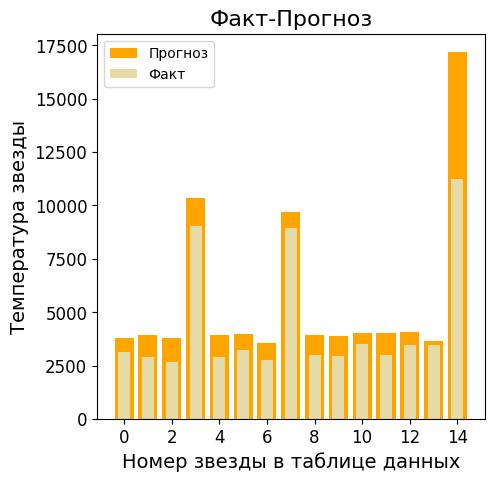

In [601]:
show_graph(model_drpt(X_test_slr))

**Выводы**

В сравнении с первой моделью, модель с Dropout дает прогноз с RMSE 2919 на тестовой выборке, однако визульное сравнение Факт-Прогноз, говорит о том, что первая модель справилась с задачей лучше

# Выводы

Целью проекта было замоделировать нейросеть и обучить ее для определения температуры на поверхности обнаруженных звёзд

Заказчику было важно:

- качество прогноза (RMSE < 4500);
- отклонение прогноза от фактических значений.

Выполненые задачи:
- Загрузка датасетов и предварительный обзор данных;
- Исследовательский анализ данных;
- Разработка модели и алгоритма подбора наилучших параметров;
- Обучение базовых моделей и подбор параметров для финальных моделей;
- Тестирование.

**Загрузка датасетов и EDA**
В результате анализа данных были выявлены и отфильтрованы выбросы в параметре Радиус по значению одного стандартного отклонения. Пропусков в данных нет, однако были обнаружены неявные дубликаты в описании цветов звезд, дубликаты были устранены.

Рассмотрена корреляция Phi(k) и статестическая значимость корреляция, которая в целом подтверждает вычисленные корреляции.

Выполнено кодирование данных и проведено исследование мультиколлениарности, в результате которого признаки были оставлены.

**Baseline**
Обучены четыре типа нейронных сетей при четырех скрытых слоях с количеством нейронов 75, 50, 25, 10. Значение learning rate = 0.01, размер батча 100, количество итераций 50000

- Модель 1: Без использования технологий BatchNormaliztion и Dropout
    - RMSE test: 3827.67
    - Время обучения: 42 сек 
- Модедь 2: Без использования технологии Dropout
    - RMSE test = 3421.77
    - Время обучения: 4 мин 35 сек 
- Модель 3: Без использования технологии BatchNormaliztion
    - RMSE test = 4772.28
    - Время обучения: 53 сек 
- Модель 4: С использованием технологий BatchNormaliztion и Dropout
    - RMSE test = 4826.70
    - Время обучения: 4 мин 49 сек 

По результатам обучения базовых моделей было предложено выбрать наилучшую модель из двух вариантов Модель 1 и Модель 3

**Заключение**

В результате подбора параметров и обучения нейронных сетей наилучший результат в совокупности с значениями RMSE, временем обучения и соотношением прогноз-факт стала модель 1 с параметрами:

Четыре скрытых слоях с количеством нейронов 75, 50, 25, 10. Значение learning rate = 0.001, размер батча 100, количество итераций 150000

- RMSE Train	3364.415848
- RMSE Test	    3078.799766